In [10]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import scipy.stats as stats
import pandas as pd
import math
import cartopy.crs as ccrs

In [19]:
adcp_raw = pd.read_csv('../RCS data backup/Data/S315_adcp.csv')

time = np.unique(adcp_raw['dttm']) # get unique times

# convert to np datetimes, these are already in UTC
for i in range(len(time)):
    time[i] = np.datetime64(str(time[i])[:-1])

depth = np.unique(np.round(adcp_raw['depth'], 1)) # get unique depths 

shape = [np.shape(time)[0], np.shape(depth)[0]]

# reshape using time and depth as dimensions
lat = np.reshape(np.array(adcp_raw['lat']), shape)[:,0]
lon = np.reshape(np.array(adcp_raw['lon']), shape)[:,0]
velocity_u = np.reshape(np.array(adcp_raw['u']), shape)
velocity_v = np.reshape(np.array(adcp_raw['v']), shape)
speed = np.reshape(np.array(adcp_raw['sp']), shape)
direction = np.reshape(np.array(adcp_raw['dir']), shape)
error = np.reshape(np.array(adcp_raw['err']), shape)
backscatter = np.reshape(np.array(adcp_raw['backscat']), shape)

# calculate track distance from gsw
track_dist = np.concatenate([[0], np.cumsum(gsw.distance(lon, lat))]) / 1000

adcp = xr.Dataset(
    data_vars=dict(
        lat=(['time'], lat),
        lon=(['time'], lon),
        track_dist=(['time'], track_dist),
        velocity_u=(['time', 'depth'], velocity_u),
        velocity_v=(['time', 'depth'], velocity_v),
        speed=(['time', 'depth'], speed),
        direction=(['time', 'depth'], direction),
        error=(['time', 'depth'], error),
        backscatter=(['time', 'depth'], backscatter)
    ),
    coords=dict(
        depth=depth,
        time=time
    ),
    attrs=dict(description=""),
)

# BAD DATA FROM IDX 131-198, 422-426, 

adcp_500m = adcp.where(adcp.depth < 500, drop=True) # why does this assign additional coords to lat and lon?
adcp


<xarray.Dataset>
Dimensions:      (time: 1042, depth: 80)
Coordinates:
  * depth        (depth) float64 18.7 28.7 38.7 48.7 ... 778.7 788.7 798.7 808.7
  * time         (time) datetime64[ns] 2024-05-10T21:37:27 ... 2024-05-27T14:...
Data variables:
    lat          (time) float64 -17.52 -17.48 -17.44 ... -18.79 -18.82 -18.85
    lon          (time) float64 -149.6 -149.6 -149.6 ... -136.8 -136.8 -136.7
    track_dist   (time) float64 0.0 4.585 9.588 ... 3.016e+03 3.019e+03
    velocity_u   (time, depth) float64 0.192 0.141 0.056 0.08 ... nan nan nan
    velocity_v   (time, depth) float64 0.097 0.073 0.115 0.103 ... nan nan nan
    speed        (time, depth) float64 0.2151 0.1588 0.1279 ... nan nan nan
    direction    (time, depth) float64 63.2 62.63 25.96 37.84 ... nan nan nan
    error        (time, depth) float64 -0.018 -0.005 -0.006 ... nan nan nan
    backscatter  (time, depth) float64 164.2 157.2 147.2 ... 16.75 17.0 12.75
Attributes:
    description:

In [88]:
adcp.speed.mean()

<xarray.DataArray 'speed' ()>
array(0.13149444)

In [20]:
def area_avg(ds, lat_min, lat_max, lon_min, lon_max, variable='speed'):
    '''
    Area average of ADCP variable over a box. Min and max values are exclusive.
    '''
    if lat_min >= lat_max or lon_min >= lon_max:
        print("Invalid bounaries.")

    subset = ds.where(ds.lat > lat_min, drop=True).where(ds.lat < lat_max, drop=True).where(ds.lon > lon_min, drop=True).where(ds.lon < lon_max, drop=True)

    return subset[variable].mean(dim='time')

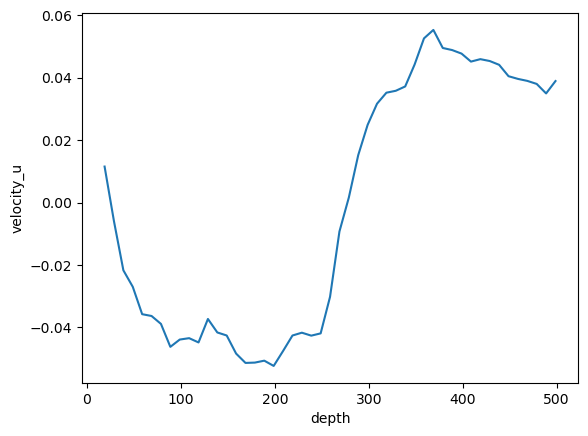

In [370]:
area_avg(adcp_500m, -11, -8, -142, -140, variable='velocity_u').plot()

Text(0.5, 1.0, 'North Component Currents (m/s)')

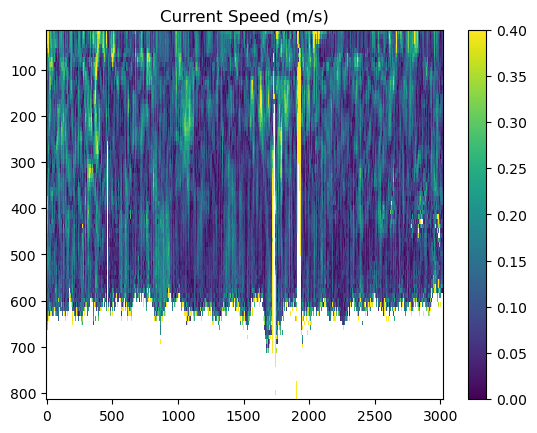

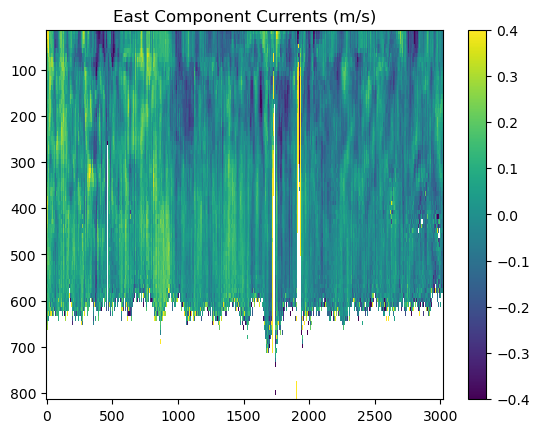

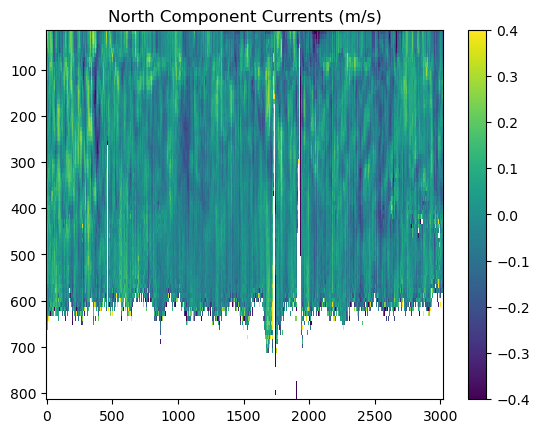

In [450]:
# speed
plt.figure()
plt.pcolormesh(adcp.track_dist, adcp.depth, adcp.speed.T, vmin=0, vmax=0.4)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Current Speed (m/s)')

# east component
plt.figure()
plt.pcolormesh(adcp.track_dist, adcp.depth, adcp.velocity_u.T, vmin=-0.4, vmax=0.4)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('East Component Currents (m/s)')

# north component
plt.figure()
plt.pcolormesh(adcp.track_dist, adcp.depth, adcp.velocity_v.T, vmin=-0.4, vmax=0.4)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('North Component Currents (m/s)')

Calculate Reynold's number

In [21]:
def calc_reynolds(ds, max_depth, lat_min, lat_max, lon_min, lon_max, l=30000, nu=100):
    '''
    Length scale l in meters
    '''
    depth_idx = int(max_depth/10) - 1 if max_depth > ds.depth[0] else 0
    
    # get mean velocities from surface to specified depth
    avg_vel_u = np.mean(area_avg(ds, lat_min, lat_max, lon_min, lon_max, variable='velocity_u')[:depth_idx])
    avg_vel_v = np.mean(area_avg(ds, lat_min, lat_max, lon_min, lon_max, variable='velocity_v')[:depth_idx])
    avg_vel = math.sqrt(avg_vel_u**2 + avg_vel_v**2)

    return avg_vel*l / nu

In [24]:
calc_reynolds(adcp, 30, -15, -8.5, -150, -138)

13.100003274357968

In [27]:
def nearest(da, val):
    return np.argmin(np.abs(da - val))

def bootstrap_reynolds(ds, lat_min_range, lat_max_range, lon_min_range, lon_max_range):

    values = []
    for i in range(1000):
        lat_min_idx = np.array([nearest(adcp.lat.values, lat_min_range[0]), nearest(adcp.lat.values, lat_min_range[1])])
        lat_max_idx = np.array([nearest(adcp.lat.values, lat_max_range[0]), nearest(adcp.lat.values, lat_max_range[1])])
        lon_min_idx = np.array([nearest(adcp.lon.values, lon_min_range[0]), nearest(adcp.lon.values, lon_min_range[1])])
        lon_max_idx = np.array([nearest(adcp.lon.values, lon_max_range[0]), nearest(adcp.lon.values, lon_max_range[1])])

        lat_min = adcp.lat[np.random.randint(np.min(lat_min_idx), np.max(lat_min_idx))].values
        lat_max = adcp.lat[np.random.randint(np.min(lat_max_idx), np.max(lat_max_idx))].values
        lon_min = adcp.lon[np.random.randint(np.min(lon_min_idx), np.max(lon_min_idx))].values
        lon_max = adcp.lon[np.random.randint(np.min(lon_max_idx), np.max(lon_max_idx))].values

        values.append(calc_reynolds(ds, 30, lat_min, lat_max, lon_min, lon_max))
    
    #plt.figure()
    #plt.hist(values)

    return values


In [28]:
reynolds_vals = bootstrap_reynolds(adcp, [-10, -9.8], [-9, -8.8], [-141, -140.8], [-139.8, -139.6])

33.5619243041964 33.06821239509242 2.832711267632383


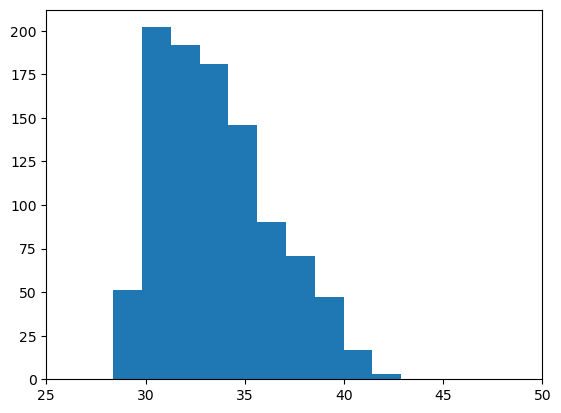

In [33]:
plt.hist(reynolds_vals)
plt.xlim(25, 50)
print(np.mean(reynolds_vals), np.median(reynolds_vals), np.std(reynolds_vals))

/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_1441/2759078734.py:56: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar2 = plt.colorbar(im2, shrink=0.25, extend='max', location='left', ticklocation='right')


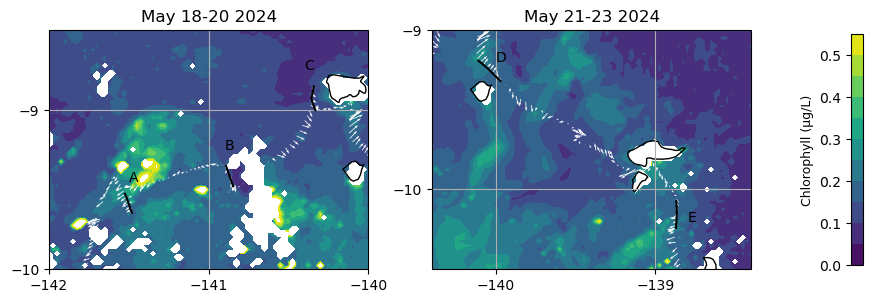

In [87]:
chla_satellite = xr.open_dataset('../data/3-day 0.025 degree aquaModis/combined.nc')
toyo = {}
for i in range(2,8):
    toyo[i] = xr.open_dataset(f'../data/derived shipdata/toyo_{i}_15S.nc')

def format_map(ax, leg=[0,1], extent=[-142, -138, -11, -8]):
    if leg == 0:
        toyos_to_plot = [2,3,4]
    elif leg == 1:
        toyos_to_plot = [5,7]
    elif leg == [0,1]:
        toyos_to_plot = [2,3,4,5,7]

    for j in toyos_to_plot:
        ax.plot(toyo[j].lon, toyo[j].lat, transform=ccrs.PlateCarree(), color='k')

    if leg == 0 or leg == [0,1]:
        ax.text(-141.5, -9.45, 'A', transform=ccrs.PlateCarree())
        ax.text(-140.9, -9.25, 'B', transform=ccrs.PlateCarree())
        ax.text(-140.4, -8.75, 'C', transform=ccrs.PlateCarree())
        if leg == [0,1]:
            ax.text(-140, -9.2, 'D', transform=ccrs.PlateCarree())
            ax.text(-138.8, -10.2, 'E', transform=ccrs.PlateCarree())
    elif leg == 1:
        ax.text(-140, -9.2, 'D', transform=ccrs.PlateCarree())
        ax.text(-138.8, -10.2, 'E', transform=ccrs.PlateCarree())

    #ax.scatter(gps_position.lon, gps_position.lat, s=1, color='grey')
    ax.set_xticks(np.linspace(-142, -138, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-11, -8, 4), crs=ccrs.PlateCarree())
    ax.set_extent(extent)
    ax.coastlines()
    ax.grid()

fig = plt.figure(figsize=(14,12))
ax = plt.subplot(1,3,1, projection=ccrs.PlateCarree())
format_map(ax, leg=0, extent=[-142, -140, -10, -8.5])
chla_satellite_time_avg = chla_satellite.chlorophyll.isel(time=3, altitude=0)
ax.contourf(chla_satellite_time_avg.longitude, 
           chla_satellite_time_avg.latitude,
           chla_satellite_time_avg, np.arange(0, 0.6, 0.05), cmap='viridis')
ax.quiver(adcp.lon, adcp.lat, adcp.isel(depth=1).velocity_u, adcp.isel(depth=1).velocity_v, color='w')
ax.set_title('May 18-20 2024')

ax = plt.subplot(1,3,2, projection=ccrs.PlateCarree())
format_map(ax, leg=1, extent=[-140.4, -138.4, -10.5, -9])
chla_satellite_time_avg = chla_satellite.chlorophyll.isel(time=6, altitude=0)
im2 = ax.contourf(chla_satellite_time_avg.longitude, 
           chla_satellite_time_avg.latitude,
           chla_satellite_time_avg, np.arange(0, 0.6, 0.05), cmap='viridis')
ax.quiver(adcp.lon, adcp.lat, adcp.isel(depth=1).velocity_u, adcp.isel(depth=1).velocity_v, color='w')
ax.set_title('May 21-23 2024')

ax = plt.subplot(1,3,3)
#cbar = plt.colorbar(im, shrink=0.3, extend='both', location='left')
cbar2 = plt.colorbar(im2, shrink=0.25, extend='max', location='left', ticklocation='right')
#cbar.set_label('Fluorescence (arbitrary units)', fontsize=9)
cbar2.set_label('Chlorophyll (µg/L)', fontsize=9)
ax.remove()
plt.savefig('figures/surface_currents.jpg', dpi=300, bbox_inches='tight')

# for idx in (0, 4, 8):
#     plt.figure()
#     plt.quiver(adcp.lon, adcp.lat, -adcp.isel(depth=idx).velocity_u, -adcp.isel(depth=idx).velocity_v)
#     plt.xlim(-141, -139.5)
#     plt.ylim(-10,-8.8)
#     plt.title(f'Depth: {adcp.depth[idx].values} m')

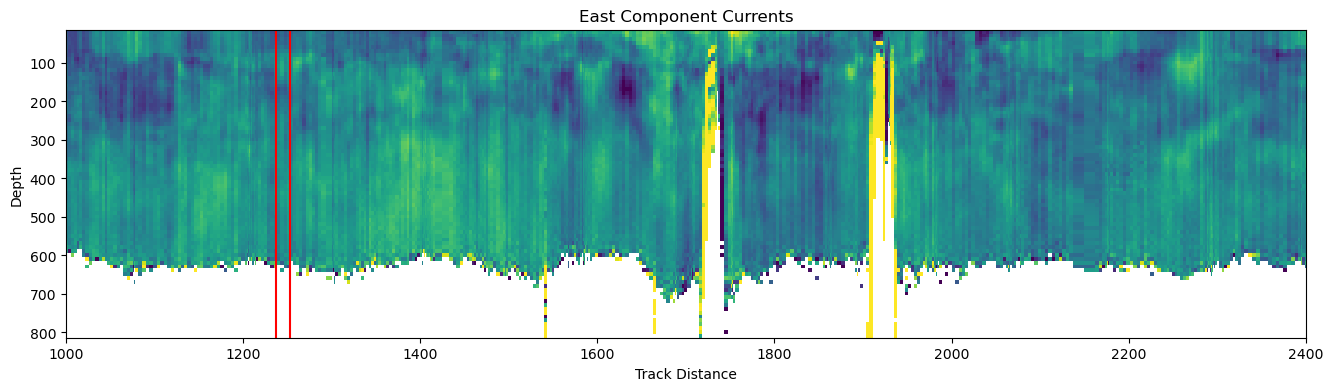

In [545]:
track_dist_toyoA = [gsw.distance([adcp.lon[0], -141.48032933], [adcp.lat[0], -9.64643467])[0]/1000, gsw.distance([adcp.lon[0], -141.52463], [adcp.lat[0], -9.52711278])[0]/1000]

# need to get track distance since start of trip from coordinates

fig, ax = plt.subplots(figsize=(16, 4))
ax.pcolormesh(adcp.track_dist, adcp.depth, adcp.velocity_u.T, vmin=-0.4, vmax=0.4)
ax.invert_yaxis()
ax.set(xlim=[1000, 2400], xlabel='Track Distance', ylabel='Depth', title='East Component Currents')
ax.axvline(track_dist_toyoA[0], color='r')
ax.axvline(track_dist_toyoA[0]+15, color='r')

# Vertical velocity

In [53]:
def calc_dx_dy(lat, lon):
    assert(len(lat) == len(lon))
    dx, dy = [], []
    for i in range(len(lat) - 1):
        dx.append(gsw.distance((lon[i], lon[i+1]), (lat[i], lat[i])))
        dy.append(gsw.distance((lon[i], lon[i]), (lat[i], lat[i+1])))
    return dx, dy

In [55]:
# calculate horizontal derivatives
du = adcp.velocity_u.diff('time')
dv = adcp.velocity_v.diff('time')

dx, dy = calc_dx_dy(adcp.lat, adcp.lon)

dudx = du / dx
dvdy = dv / dy

In [64]:
dz = adcp.depth.diff('depth')

w = -(dudx + dvdy).cumsum('depth')


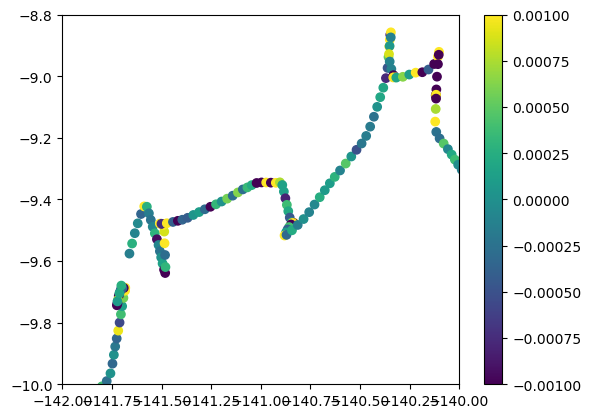

In [84]:
plt.scatter(adcp.lon[:-1], adcp.lat[:-1], c=w.isel(depth=10), vmin=-0.001, vmax=0.001)
plt.ylim(-10,-8.8)
plt.xlim(-142, -140)
plt.colorbar()